In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

np.random.seed(123)   # para reproducibilidad

beta = 0.1            # parámetro del ejercicio
n_total = 50_000      # longitud total a simular
burn_in = 1_000       # pasos iniciales a descartar ("calentamiento")

In [2]:
X = np.zeros(n_total)
for t in range(1, n_total):
    eps = np.random.normal(0.0, 1.0)      # "ruido" ~ N(0,1)
    X[t] = beta * X[t-1] + eps

# Se descarta el burn-in y se trabaja con la parte "estable"
Xs = X[burn_in:]
len(Xs)

49000

In [3]:
var_teorica = 1.0 / (1.0 - beta**2)
desv_teorica = np.sqrt(var_teorica)

In [4]:
media_muestral = Xs.mean()
var_muestral   = Xs.var(ddof=1)
desv_muestral  = np.sqrt(var_muestral)

# correlación simple entre X_t y X_{t-1}
corr_lag1 = np.corrcoef(Xs[1:], Xs[:-1])[0,1]

print(f"Media muestral      : {media_muestral: .4f} (teórica: 0.0000)")
print(f"Varianza muestral   : {var_muestral: .4f} (teórica: {var_teorica: .4f})")
print(f"Desv. estándar mues.: {desv_muestral: .4f} (teórica: {desv_teorica: .4f})")
print(f"Correlación lag 1   : {corr_lag1: .4f} (esperado ~ beta = {beta})")

Media muestral      :  0.0080 (teórica: 0.0000)
Varianza muestral   :  1.0112 (teórica:  1.0101)
Desv. estándar mues.:  1.0056 (teórica:  1.0050)
Correlación lag 1   :  0.1061 (esperado ~ beta = 0.1)


Lectura esperada:


*   La media muestral debe ser cercana a 0.
*   La varianza muestral debe ser cercana a $1/(1-\beta^2)=1/0.99≈1.0101$
*   La correlación con el valor anterior debe ser cercana a $\beta = 0.1$ indica que $X_t$ se parece a $X_{t-1}$



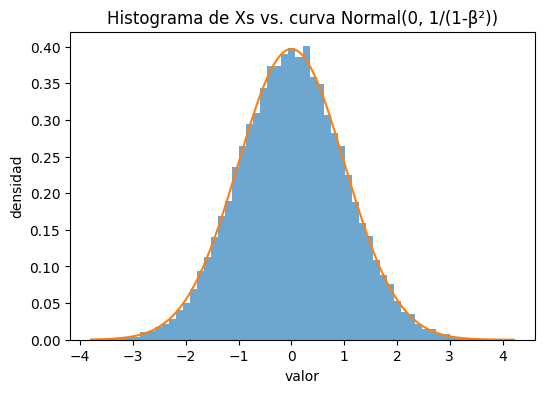

In [5]:
plt.figure(figsize=(6,4))
plt.hist(Xs, bins=60, density=True, alpha=0.65)
grid = np.linspace(Xs.min(), Xs.max(), 400)
plt.plot(grid, stats.norm.pdf(grid, loc=0.0, scale=desv_teorica))
plt.title("Histograma de Xs vs. curva Normal(0, 1/(1-β²))")
plt.xlabel("valor")
plt.ylabel("densidad")
plt.show()

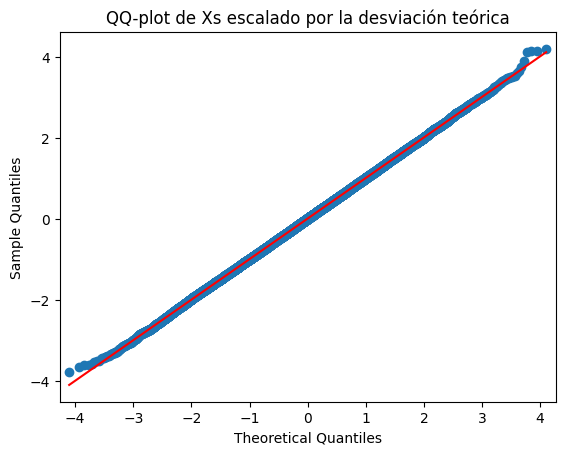

In [6]:
# Para ajustar a media y varianza teóricas, estandarizar con esas:
Z = Xs / desv_teorica  # si la teoría es correcta, Z debería verse ~Normal(0,1)
sm.qqplot(Z, line='s')
plt.title("QQ-plot de Xs escalado por la desviación teórica")
plt.show()

Lectura esperada:

El histograma debe parecerse a una “campana” centrada en 0; la curva teórica dibujada encima debería ajustar bien.

En el QQ-plot, los puntos deberían alinearse con la recta de referencia (lo que sugiere forma normal).

Autocorrelaciones (lags 0..10): [ 1.     0.106  0.007 -0.008 -0.    -0.003 -0.007 -0.     0.001  0.004
  0.002]


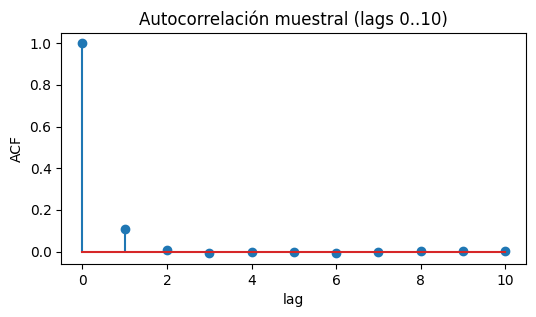

In [8]:
acf_vals = sm.tsa.stattools.acf(Xs, nlags=10, fft=True)
print("Autocorrelaciones (lags 0..10):", np.round(acf_vals, 3))

plt.figure(figsize=(6,3))
plt.stem(range(len(acf_vals)), acf_vals)
plt.title("Autocorrelación muestral (lags 0..10)")
plt.xlabel("lag")
plt.ylabel("ACF")
plt.show()

Lectura esperada:

El valor en lag 1 cerca de 0.1, y lags mayores rápidamente más pequeños.

In [9]:
# Shapiro-Wilk en una submuestra (la prueba no es pensada para decenas de miles de datos)
sw_stat, sw_p = stats.shapiro(Xs[:5000])
print(f"Shapiro-Wilk p-valor (submuestra 5000): {sw_p: .4f}")

# KS contra Normal con media=0 y desviación teórica (o muestral)
ks_stat, ks_p = stats.kstest(Xs, 'norm', args=(0.0, desv_teorica))
print(f"KS p-valor contra N(0, desv_teorica):  {ks_p: .4f}")

Shapiro-Wilk p-valor (submuestra 5000):  0.1792
KS p-valor contra N(0, desv_teorica):   0.3440


Lectura esperada:

P-valores “no muy pequeños” suelen ser compatibles con la normalidad teórica. (Si salieran bajos, revisar tamaño de muestra, escalado y gráficos; a tamaños enormes, pequeñas desviaciones pueden detectarse aunque no sean relevantes en práctica).